In [4]:
import xarray as xr
import os
from pathlib import Path
DATA_PATH = Path(os.getenv("DATA_PATH"))

data_path_1 = DATA_PATH / "sat2/stage_data_proba_250hz_part1.nc"

In [5]:
ds = xr.load_dataset(data_path_1)
ds

<xarray.Dataset> Size: 7GB
Dimensions:        (participant: 9, epochs: 2445, channels: 64, samples: 622,
                    labels: 5)
Coordinates:
  * epochs         (epochs) int64 20kB 0 1 2 3 4 5 ... 2442 2443 2444 2445 2446
  * channels       (channels) <U3 768B 'Fp1' 'AF7' 'AF3' ... 'PO8' 'PO4' 'O2'
  * samples        (samples) int64 5kB 0 1 2 3 4 5 6 ... 616 617 618 619 620 621
  * participant    (participant) <U3 108B 'S1' 'S10' 'S11' ... 'S16' 'S17' 'S18'
    event_name     (participant, epochs) <U21 2MB '' ... 'high/speed/left/3'
    rt             (participant, epochs) float64 176kB nan 0.4092 ... 0.2861
Dimensions without coordinates: labels
Data variables:
    data           (participant, epochs, channels, samples) float64 7GB nan ....
    probabilities  (participant, epochs, labels, samples) float32 274MB 0.0 ....
Attributes:
    sfreq:           256.0
    offset:          0
    lowpass:         82.58064516129032
    highpass:        1.0
    lower_limit_RT:  0.25
    upper_limit_RT:  2.5

In [11]:
%load_ext autoreload
%autoreload 2
from hmpai.pytorch.normalization import *
from hmpai.pytorch.generators import MultiXArrayProbaDataset
from hmpai.training import split_participants
from pathlib import Path
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))

data_path_1 = DATA_PATH / "sat2/stage_data_proba_250hz_part1.nc"
data_path_2 = DATA_PATH / "sat2/stage_data_proba_250hz_part2.nc"

ds = xr.load_dataset(data_path_1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
len(ds.samples)

622

In [25]:
ds.isel(participant=0, epochs=1, samples=range(0, 11))

<xarray.Dataset> Size: 7kB
Dimensions:        (channels: 64, samples: 11, labels: 5)
Coordinates:
    epochs         int64 8B 1
  * channels       (channels) <U3 768B 'Fp1' 'AF7' 'AF3' ... 'PO8' 'PO4' 'O2'
  * samples        (samples) int64 88B 0 1 2 3 4 5 6 7 8 9 10
    participant    <U3 12B 'S1'
    event_name     <U21 84B 'low/speed/right/1'
    rt             float64 8B 0.4092
Dimensions without coordinates: labels
Data variables:
    data           (channels, samples) float64 6kB 8.944e-06 ... -1.59e-07
    probabilities  (labels, samples) float32 220B 0.0 0.0 ... 2.695e-11
Attributes:
    sfreq:           256.0
    offset:          0
    lowpass:         82.58064516129032
    highpass:        1.0
    lower_limit_RT:  0.25
    upper_limit_RT:  2.5

In [11]:
ds.participant

<xarray.DataArray 'participant' (participant: 9)> Size: 108B
array(['S1', 'S10', 'S11', 'S12', 'S13', 'S15', 'S16', 'S17', 'S18'],
      dtype='<U3')
Coordinates:
  * participant  (participant) <U3 108B 'S1' 'S10' 'S11' ... 'S16' 'S17' 'S18'

In [29]:
epoch = ds.sel(participant='S1', epochs=20)
print(epoch.event_name.item())
print(epoch.probabilities.to_numpy().sum(axis=1))
# Speed = [0, 1, 1, 0, 1]
# Accuracy = [0, 1, 1, 1, 1]
# Sometimes sum = < 1, but not 0
# Where does the first one come from?
# Probably because pre-attentive does not have a bump, makes sense.

low/speed/left/2
[0. 1. 1. 0. 1.]


In [107]:
rand = np.random.uniform()

In [78]:
data = ds["data"].values
data_subset = data[..., 0, :]
mask = np.isnan(data_subset).all(axis=-1)
# Mask contains indices that ARE nan, so select inverse

indices = np.argwhere(~mask)

In [10]:
ds

NameError: name 'ds' is not defined

In [85]:
probas = ds["probabilities"].values
event_locs = probas.argmax(axis=-1)
# Indices where at least one location is found
indices = np.argwhere(event_locs.sum(axis=2) != 0)

In [90]:
event_locs[indices[0, 0], indices[0, 1]]

array([ 0,  3, 33,  0, 96])

In [86]:
event_locs.shape

(9, 2445, 5)

In [87]:
indices

array([[   0,    1],
       [   0,    2],
       [   0,    5],
       ...,
       [   8, 2432],
       [   8, 2433],
       [   8, 2434]])

In [83]:
len(indices)

20034

In [65]:
event_locs

array([[[  0,   0,   0,   0,   0],
        [  0,   3,  33,   0,  96],
        [  0,   5,  28,   0,  93],
        ...,
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   3,  27,  76, 176],
        [  0,   5,  43, 100, 143],
        [  0,   6,  44, 103, 129],
        ...,
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   9,  70,   0, 188],
        [  0,   4,  70,   0, 173],
        [  0,   5,  29,   0, 186],
        ...,
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       ...,

       [[  0,   6,  34,  86, 179],
        [  0,   5,  37,  90, 318],
        [  0,   5,  32, 116, 237],
        ...,
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,  11,  51,   0, 121],
        [  0,  13,  32,   0,  85],
        [  0,   3

In [53]:
indices.size

40144

In [55]:
indices.shape

(20072, 2)

In [14]:
%load_ext autoreload
%autoreload 2
from hmpai.pytorch.normalization import *
from hmpai.pytorch.generators import MultiXArrayProbaDataset
from hmpai.training import split_participants
from pathlib import Path
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))

data_path_1 = DATA_PATH / "sat2/stage_data_proba_250hz_part1.nc"
data_path_2 = DATA_PATH / "sat2/stage_data_proba_250hz_part2.nc"
# data_paths = [data_path_1, data_path_2]
data_paths = [data_path_1]
splits = split_participants(data_paths, train_percentage=80)
norm_fn = norm_min1_to_1
dataset_train = MultiXArrayProbaDataset(data_paths, participants_to_keep=splits[0], normalization_fn=norm_fn)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/workspace/hmp-ai/src/hmpai/pytorch/generators.py:335: RuntimeWarning: All-NaN slice encountered
  sample_min = np.nanmin(data)
/workspace/hmp-ai/src/hmpai/pytorch/generators.py:336: RuntimeWarning: All-NaN slice encountered
  sample_max = np.nanmax(data)


In [18]:
dataset_train.__getitem__(1)[0][:,0]

tensor([-0.0392, -0.0476, -0.0251, -0.0072,  0.0171,  0.0334,  0.0206,  0.0217,
         0.0218, -0.0001,  0.0088])

In [98]:
dataset_train.index_map

[(0, 0, 1, 3, 1),
 (0, 0, 1, 33, 2),
 (0, 0, 1, 96, 4),
 (0, 0, 2, 5, 1),
 (0, 0, 2, 28, 2),
 (0, 0, 2, 93, 4),
 (0, 0, 5, 8, 1),
 (0, 0, 5, 32, 2),
 (0, 0, 5, 108, 4),
 (0, 0, 6, 6, 1),
 (0, 0, 6, 57, 2),
 (0, 0, 6, 110, 4),
 (0, 0, 7, 5, 1),
 (0, 0, 7, 49, 2),
 (0, 0, 7, 105, 4),
 (0, 0, 8, 3, 1),
 (0, 0, 8, 30, 2),
 (0, 0, 8, 98, 4),
 (0, 0, 9, 5, 1),
 (0, 0, 9, 30, 2),
 (0, 0, 9, 115, 4),
 (0, 0, 10, 6, 1),
 (0, 0, 10, 32, 2),
 (0, 0, 10, 106, 4),
 (0, 0, 11, 13, 1),
 (0, 0, 11, 34, 2),
 (0, 0, 11, 123, 4),
 (0, 0, 12, 3, 1),
 (0, 0, 12, 26, 2),
 (0, 0, 12, 195, 4),
 (0, 0, 13, 8, 1),
 (0, 0, 13, 35, 2),
 (0, 0, 13, 101, 4),
 (0, 0, 14, 5, 1),
 (0, 0, 14, 32, 2),
 (0, 0, 14, 104, 4),
 (0, 0, 15, 7, 1),
 (0, 0, 15, 27, 2),
 (0, 0, 15, 75, 4),
 (0, 0, 16, 7, 1),
 (0, 0, 16, 30, 2),
 (0, 0, 16, 85, 4),
 (0, 0, 17, 5, 1),
 (0, 0, 17, 31, 2),
 (0, 0, 17, 93, 4),
 (0, 0, 18, 6, 1),
 (0, 0, 18, 26, 2),
 (0, 0, 18, 96, 4),
 (0, 0, 19, 8, 1),
 (0, 0, 19, 32, 2),
 (0, 0, 19, 93, 4),
 (0, 0, 

In [11]:
dataset_train = MultiXArrayDataset(data_paths, participants_to_keep=splits[0], normalization_fn=norm_fn)

50360.0
10223
9847


In [12]:
len(dataset_train.index_map)

39319

In [4]:
import torch
cls_token = torch.zeros(1, 1, 50)

In [7]:
print(cls_token.shape)
cls_token = cls_token.expand((64, -1, -1))
print(cls_token.shape)

torch.Size([1, 1, 50])
torch.Size([64, 1, 50])


In [9]:
%matplotlib

Using matplotlib backend: <object object at 0x7f57cc0bd240>


In [12]:
import eeg_positions
import matplotlib.pyplot as plt
data = eeg_positions.get_elec_coords(system='1010', dim='3d')
data

,label,x,y,z
0,Nz,0.0000,1.0000,0.0000
1,T10,1.0000,0.0000,0.0000
2,Iz,0.0000,-1.0000,0.0000
3,T9,-1.0000,0.0000,0.0000
4,Cz,0.0000,0.0000,1.0000
...,...,...,...,...
69,P4,0.4591,-0.5800,0.6730
70,P6,0.6408,-0.5708,0.5135
71,NAS,0.0000,1.0000,0.0000
72,RPA,1.0000,0.0000,0.0000


In [15]:
data[20:50]

,label,x,y,z
20,P9,-0.8090,-0.5878,0.0000
21,PO9,-0.5878,-0.8090,0.0000
22,I1,-0.3090,-0.9511,0.0000
23,T7,-0.9511,0.0000,0.3090
24,C5,-0.8090,0.0000,0.5878
25,C3,-0.5878,0.0000,0.8090
26,C1,-0.3090,0.0000,0.9511
27,C2,0.3090,0.0000,0.9511
28,C4,0.5878,0.0000,0.8090
29,C6,0.8090,0.0000,0.5878


In [5]:
import numpy as np
# Robust z-score the data
signals = np.random.random((100, 19, 150))
signals[0, 0, 0] = 100000
median = np.median(signals)
mad = np.median(np.abs(signals - median), keepdims=True)
mad[mad == 0] = 1e-6
z_scored_signals = (signals - median) / mad

In [8]:
z_scored_signals.max()

399273.6778463656

In [27]:
import h5py
from pathlib import Path
import pandas as pd
PATH_BASE = Path("../data/tueg_split")
# with h5py.File(PATH_BASE / '711547_4.h5', 'r') as file:
#     file = file
file = h5py.File(PATH_BASE / '899442_390.h5', 'r')

In [18]:
for i, j in file['participants/aaaaanud/sessions'].items():
    print(i, j)
    print(file['participants/aaaaanud/sessions/{session}'])

s003 <HDF5 group "/participants/aaaaanud/sessions/s003" (1 members)>
s004 <HDF5 group "/participants/aaaaanud/sessions/s004" (1 members)>


In [25]:
index_map = {'path': [], 'participant': [], 'session': [], 'n_samples': []}
for participant in file['participants']:
    for session in file[f'participants/{participant}/sessions']:
        # print(participant, session)
        for dataset in file[f'participants/{participant}/sessions/{session}']:
            n_samples = file[f'participants/{participant}/sessions/{session}/{dataset}'].shape[0]
            index_map['participant'].append(participant)
            index_map['session'].append(session)
            index_map['n_samples'].append(n_samples)

In [28]:
pd.DataFrame(index_map)

,participant,session,n_samples
0,aaaaanud,s003,6148
1,aaaaanud,s004,2208
2,aaaaanue,s001,2213
3,aaaaanuf,s001,2203
4,aaaaanuf,s002,2210
...,...,...,...
159,aaaaanyc,s001,2506
160,aaaaanyc,s002,2105
161,aaaaanyc,s003,2138
162,aaaaanyc,s004,6661


In [3]:
for participant in file['participants']:
    print(f'Participant: {participant}')
    for session in file[f'participants/{participant}/sessions']:
        print(f'  Session: {session}')
        session_group = file[f'participants/{participant}/sessions/{session}']
        for dataset_name in session_group:
            data = session_group[dataset_name][:]
            print(f'    Dataset {dataset_name}: shape {data.shape}')

Participant: aaaaanud
  Session: s003
    Dataset data: shape (6148, 19, 150)
  Session: s004
    Dataset data: shape (2208, 19, 150)
Participant: aaaaanue
  Session: s001
    Dataset data: shape (2213, 19, 150)
Participant: aaaaanuf
  Session: s001
    Dataset data: shape (2203, 19, 150)
  Session: s002
    Dataset data: shape (2210, 19, 150)
Participant: aaaaanug
  Session: s001
    Dataset data: shape (2279, 19, 150)
Participant: aaaaanuh
  Session: s001
    Dataset data: shape (2148, 19, 150)
Participant: aaaaanui
  Session: s001
    Dataset data: shape (2214, 19, 150)
  Session: s002
    Dataset data: shape (2370, 19, 150)
Participant: aaaaanuj
  Session: s001
    Dataset data: shape (2381, 19, 150)
  Session: s002
    Dataset data: shape (2300, 19, 150)
  Session: s003
    Dataset data: shape (2203, 19, 150)
Participant: aaaaanuk
  Session: s001
    Dataset data: shape (2370, 19, 150)
Participant: aaaaanul
  Session: s001
    Dataset data: shape (2510, 19, 150)
Participant: aaaaa

KeyboardInterrupt: 

In [2]:
ls = [(1, i) for i in range(100)]

In [4]:
import timeit

# List comprehension
time_list_comp = timeit.timeit('[(1, i) for i in range(100)]', number=100000)

# Traditional for-loop
time_for_loop = timeit.timeit('ls = []\nfor i in range(100):\n    ls.append((1, i))', number=100000)

print(f"List comprehension time: {time_list_comp}")
print(f"For-loop time: {time_for_loop}")

List comprehension time: 0.3966547059826553
For-loop time: 0.569465272128582


In [1]:
import numpy as np
from multiprocessing import Pool
# Used to convert all float64 edf files to float32
def parallelize_list(files, func, num_cores=None):
    num_cores = multiprocessing.cpu_count() - 1 if num_cores is None else num_cores  #leave one free to not freeze machine
    num_partitions = num_cores #number of partitions to split dataframe
    df_split = np.array_split(files, num_partitions)
    pool = multiprocessing.Pool(num_cores)
    df = pool.map(func, df_split)
    pool.close()
    pool.join()
    return df

def process_files(files):
    for i, file in enumerate(files):
        if i % 10 == 0:
            print(i)
        data = np.load(file)
        data_float32 = data.astype(np.float32)
        np.save(file, data_float32)
    return None

In [ ]:
parallelize_list(files, process_files)

In [1]:
from hmpai.behaviour.sat2 import read_behavioural_info
import os
from pathlib import Path
DATA_PATH = Path(os.getenv("DATA_PATH"))
behaviour_sat2 = read_behavioural_info(DATA_PATH / "sat2/behavioural/df_full.csv")

In [3]:
behaviour_sat2.rt.mean()

569.2757891889485

In [8]:
import xarray as xr
import os
from pathlib import Path
DATA_PATH = Path(os.getenv("DATA_PATH"))

data_path1 = DATA_PATH / "sat2/split_stage_data_250hz_part2.nc"
data_part1 = xr.load_dataset(data_path1)


In [10]:
data_part1.labels

<xarray.DataArray 'labels' (labels: 5)> Size: 260B
array(['confirmation', 'decision', 'encoding', 'pre-attentive', 'response'],
      dtype='<U13')
Coordinates:
  * labels   (labels) <U13 260B 'confirmation' 'decision' ... 'response'

In [13]:
electrode_mapping = {
    'EEG FP1': 'Fp1',
    'EEG FP2': 'Fp2',
    'EEG F7': 'F7',
    'EEG F8': 'F8',
    'EEG F3': 'F3',
    'EEG F4': 'F4',
    'EEG FZ': 'Fz',
    'EEG T3': 'T7',  # T3 corresponds to T7
    'EEG T4': 'T8',  # T4 corresponds to T8
    'EEG C3': 'C3',
    'EEG C4': 'C4',
    'EEG CZ': 'Cz',
    'EEG T5': 'P7',  # T5 corresponds to P7
    'EEG T6': 'P8',  # T6 corresponds to P8
    'EEG P3': 'P3',
    'EEG P4': 'P4',
    'EEG PZ': 'Pz',
    'EEG O1': 'O1',
    'EEG O2': 'O2'
}
sat2_chs = list(electrode_mapping.values())

In [17]:
len(sat2_chs)
data_part1.sel({'channels': sat2_chs})

<xarray.Dataset> Size: 4GB
Dimensions:      (channels: 19, samples: 250, epochs: 2440, participant: 9,
                  labels: 5)
Coordinates:
  * channels     (channels) <U3 228B 'Fp1' 'Fp2' 'F7' 'F8' ... 'Pz' 'O1' 'O2'
  * samples      (samples) int64 2kB 0 1 2 3 4 5 6 ... 244 245 246 247 248 249
  * epochs       (epochs) int64 20kB 0 1 2 3 4 5 ... 2442 2443 2444 2445 2446
  * participant  (participant) <U3 108B 'S2' 'S20' 'S3' 'S4' ... 'S7' 'S8' 'S9'
  * labels       (labels) <U13 260B 'confirmation' 'decision' ... 'response'
    event_name   (participant, epochs) <U21 2MB 'low/accuracy/left/2' ... 'hi...
    rt           (participant, epochs) float64 176kB 0.5645 0.6094 ... 1.014
Data variables:
    data         (participant, epochs, labels, channels, samples) float64 4GB ...

In [9]:
ch_names = [ch.upper() for ch in list(data_part1.channels.to_numpy())]

In [10]:
ch_names

['FP1',
 'AF7',
 'AF3',
 'F1',
 'F3',
 'F5',
 'F7',
 'FT7',
 'FC5',
 'FC3',
 'FC1',
 'C1',
 'C3',
 'C5',
 'T7',
 'TP7',
 'CP5',
 'CP3',
 'CP1',
 'P1',
 'P3',
 'P5',
 'P7',
 'P9',
 'PO7',
 'PO3',
 'O1',
 'IZ',
 'OZ',
 'POZ',
 'PZ',
 'CPZ',
 'FPZ',
 'FP2',
 'AF8',
 'AF4',
 'AFZ',
 'FZ',
 'F2',
 'F4',
 'F6',
 'F8',
 'FT8',
 'FC6',
 'FC4',
 'FC2',
 'FCZ',
 'CZ',
 'C2',
 'C4',
 'C6',
 'T8',
 'TP8',
 'CP6',
 'CP4',
 'CP2',
 'P2',
 'P4',
 'P6',
 'P8',
 'P10',
 'PO8',
 'PO4',
 'O2']

In [5]:
data_part1

<xarray.Dataset> Size: 3GB
Dimensions:      (epochs: 2447, channels: 30, samples: 250, participant: 18)
Coordinates:
  * epochs       (epochs) int64 20kB 0 1 2 3 4 5 ... 2442 2443 2444 2445 2446
  * channels     (channels) <U3 360B 'Fp1' 'Fp2' 'AFz' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 2kB 0 1 2 3 4 5 6 ... 244 245 246 247 248 249
  * participant  (participant) <U3 216B 'S10' 'S11' 'S12' ... 'S7' 'S8' 'S9'
    event_name   (participant, epochs) <U21 4MB 'low/accuracy/right/3' ... 'a...
    rt           (participant, epochs) float64 352kB 0.7334 0.5977 ... 1.014
Data variables:
    data         (participant, epochs, channels, samples) float64 3GB 1.256e-...
    labels       (participant, epochs, samples) <U13 573MB 'pre-attentive' .....
Attributes:
    sfreq:           102.4
    offset:          0
    lowpass:         33.03225806451613
    highpass:        1.0
    lower_limit_RT:  0.25
    upper_limit_RT:  2.5

In [2]:
data_part1.channels

<xarray.DataArray 'channels' (channels: 30)> Size: 360B
array(['Fp1', 'Fp2', 'AFz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz',
       'C4', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2', 'FC1', 'FCz',
       'FC2', 'FC5', 'FC6', 'CP5', 'CP1', 'CPz', 'CP2', 'CP6'], dtype='<U3')
Coordinates:
  * channels  (channels) <U3 360B 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'

In [15]:
data_path1 = DATA_PATH / "sat2/stage_data_250hz_part2.nc"
data_part1 = xr.load_dataset(data_path1)
data_part1.labels = data_part1.labels.where(data_part1.labels != 'negative', 'pre-attentive')
data_path1 = DATA_PATH / "sat2/stage_data_250hz_part2_new.nc"

data_part1.to_netcdf(data_path1)

In [5]:
data_part1.labels = data_part1.labels.where(data_part1.labels == 'negative', 'pre-attentive')

AttributeError: cannot set attribute 'labels' on a 'Dataset' object. Use __setitem__ styleassignment (e.g., `ds['name'] = ...`) instead of assigning variables.

In [ ]:
import matplotlib.pyplot as plt

mask = TimeMasking(1, 20)
for i in range(10):
    data, labels = mask(val_dataset.__getitem__(0))
    print(labels)
    plt.plot(data[:, 0])
    plt.ylim(-1, 1)
    plt.show()

In [1]:
%load_ext autoreload
%autoreload 2
from hmpai.behaviour.sat2 import read_behavioural_info
import os
from pathlib import Path
import netCDF4
import xarray as xr
DATA_PATH = Path(os.getenv("DATA_PATH"))
path = DATA_PATH / "sat2/behavioural/df_full.csv"
data = read_behavioural_info(path)
xr_data = xr.load_dataset(DATA_PATH / "sat2/split_stage_data_100hz.nc")


In [ ]:
xr_data

<xarray.Dataset> Size: 5GB
Dimensions:      (channels: 30, samples: 100, epochs: 2446, participant: 18,
                  labels: 5)
Coordinates:
  * channels     (channels) <U3 360B 'Fp1' 'Fp2' 'AFz' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 800B 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * epochs       (epochs) int64 20kB 0 1 2 3 4 5 ... 2442 2443 2444 2445 2446
  * participant  (participant) <U3 216B 'S1' 'S10' 'S11' ... 'S7' 'S8' 'S9'
  * labels       (labels) <U13 260B 'confirmation' 'decision' ... 'response'
    event_name   (participant, epochs) <U21 4MB '' 'low/speed/right/1' ... ''
    rt           (participant, epochs) float64 352kB nan 0.4092 ... 1.319 nan
Data variables:
    data         (participant, epochs, labels, channels, samples) float64 5GB ...

<Axes: ylabel='Count'>

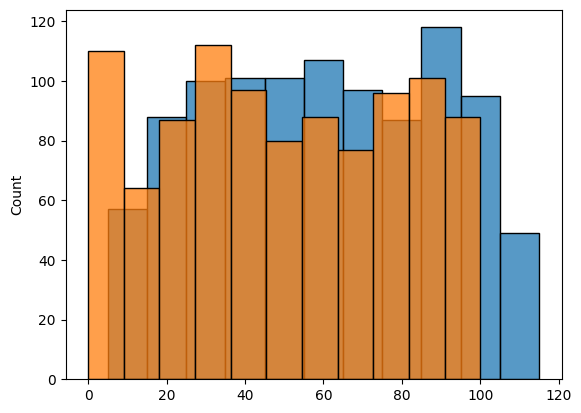

In [ ]:
import matplotlib.pyplot as plt
import random
import seaborn as sns

starts = []
ends = []
lengths = [5, 10, 15]
rt_idx = 100
for _ in range(1000):
    start = random.randint(0, rt_idx)
    max_crop_length = rt_idx - start
    crop_length = random.sample(lengths, 1)[0]
    end = start + crop_length
    ends.append(end)
    starts.append(start)
sns.histplot(ends)
sns.histplot(starts)


In [ ]:
xr_data.assign(test=(["participant", "epochs", "samples"], lambda x: x*x))

ValueError: Variable 'test': Could not convert tuple of form (dims, data[, attrs, encoding]): (['participant', 'epochs', 'samples'], <function <lambda> at 0x7ff23225d7e0>) to Variable.

In [ ]:
import numpy as np
xr_data.assign({'test': (["participant", "epochs", "samples"], np.arange(len(xr_data.participant), len(xr_data.epochs), len(xr_data.samples)))})
xr_data.assign({'test': (["participant", "epochs", "samples"], np.arange(len(xr_data.participant), len(xr_data.epochs), len(xr_data.samples)))})

ValueError: Variable 'test': Could not convert tuple of form (dims, data[, attrs, encoding]): (['participant', 'epochs', 'samples'], array([  18,  268,  518,  768, 1018, 1268, 1518, 1768, 2018, 2268])) to Variable.

In [ ]:
data = data.drop([data.columns[0], data.columns[8]], axis=1)

In [ ]:
(not 1 != 1) and True

True

In [ ]:
from hmpai.data import SAT1_STAGES_ACCURACY

SAT1_STAGES_ACCURACY[1:]

['encoding', 'decision', 'confirmation', 'response']

In [ ]:
lst = [0, 1, 2, 3, 4, 5]
n = len(lst)

start_idx = 2
current_idx = start_idx
end_idx = (start_idx - 1) % n

while True:
    print(lst[current_idx])
    if current_idx == end_idx:
        break
    current_idx = (current_idx + 1) % n

2
3
4
5
0
1


In [ ]:
for i, item in enumerate([0, 1, 2, 3, 4, 5], start=3):
    print(i, item)

3 0
4 1
5 2
6 3
7 4
8 5


In [ ]:
sl = slice(0, 1)
ls = [1, 2, 3, 4, 5]
ls[sl]

[1]

In [ ]:
sl.start = sl.start + 2

AttributeError: readonly attribute

In [ ]:
import netCDF4
import xarray as xr
import os
from pathlib import Path
from collections import Counter
DATA_PATH = Path(os.getenv("DATA_PATH"))
data_thesis = xr.load_dataset(DATA_PATH / 'sat1/thesis/stage_data_100hz.nc')
data_new = xr.load_dataset(DATA_PATH / 'sat1/stage_data_100hz.nc')
raw_thesis = xr.load_dataset(DATA_PATH / 'sat1/before_500hz/data.nc')
raw_new = xr.load_dataset(DATA_PATH / 'sat1/data_100hz.nc')

In [ ]:
raw_thesis.sel(participant='0002',epochs=0,channels='Fp1').data

<xarray.DataArray 'data' (samples: 199)> Size: 2kB
array([ 1.09207320e+00,  8.54704618e-01, -4.03182656e-01, -4.18614954e-01,
        4.30465013e-01,  3.25663716e-01, -6.73092782e-01, -1.19290829e+00,
       -1.75788403e+00, -2.69634223e+00, -2.67201757e+00, -4.89260435e+00,
       -7.65021276e+00, -6.14935112e+00, -4.86538029e+00, -5.28896379e+00,
       -3.98497367e+00, -1.71000946e+00, -7.91115820e-01, -1.35223579e+00,
       -2.18570900e+00, -2.96840739e+00, -1.62405002e+00, -4.73380148e-01,
       -1.59249675e+00,  2.05850855e-01,  2.19958353e+00, -1.51038498e-01,
       -2.03022838e+00, -1.67176878e+00, -2.33887339e+00, -4.01295614e+00,
       -3.53477573e+00, -2.11618853e+00, -3.82416224e+00, -5.67550182e+00,
       -3.13488507e+00, -1.48096251e+00, -2.56646800e+00, -1.76991165e+00,
       -2.55812740e+00, -3.45960999e+00, -2.33780980e-01,  2.83634523e-03,
       -2.80844831e+00, -3.55706453e+00, -3.73143625e+00, -2.57100868e+00,
       -7.01799631e-01, -1.08541000e+00, -7.40607738e-01,  1.94489837e-01,
       -8.54529262e-01, -4.31519568e-01, -5.19354522e-01, -2.45119071e+00,
       -1.50054121e+00, -1.16059327e+00, -2.57080770e+00, -1.91903639e+00,
       -4.71340477e-01, -1.49276972e-01, -1.54956937e+00, -2.55284810e+00,
       -2.76441836e+00, -3.34854007e+00, -3.55180120e+00, -3.48726678e+00,
       -1.77260733e+00, -4.43011045e-01, -1.04671907e+00, -1.18070209e+00,
       -1.68727851e+00, -1.29108202e+00, -7.30962157e-01, -9.21384931e-01,
        7.83656299e-01,  1.18381011e+00,  6.56987309e-01,  7.28109777e-01,
...
       -5.05756974e-01, -6.23150170e-01, -1.10809231e+00,  6.48158789e-01,
        8.47098455e-02, -1.74357724e+00, -1.18681453e-01,  1.07384968e+00,
        7.50060454e-02,  4.75493133e-01,  1.68815672e+00,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan])
Coordinates:
    epochs       int64 8B 0
    channels     <U3 12B 'Fp1'
  * samples      (samples) int64 2kB 0 1 2 3 4 5 6 ... 193 194 195 196 197 198
    stim         float64 8B 2.0
    resp         <U10 40B 'resp_right'
    rt           float64 8B 1.311
    cue          <U2 8B 'SP'
    movement     <U10 40B 'stim_right'
    trigger      <U24 96B 'SP/stim_right/resp_right'
    participant  <U4 16B '0002'

In [ ]:
raw_thesis.sel(participant='0003',epochs=0,channels='Fp1').data

<xarray.DataArray 'data' (samples: 199)> Size: 2kB
array([ -7.9885602 , -10.61393929, -10.22195339, -14.33804321,
       -11.22523212,  -0.67067522,   1.72733366,  -3.15104032,
        -4.27238321,  -1.93790901,  -2.94033647,  -6.41235352,
        -6.98065472,  -2.53283501,   3.60540318,   2.0806787 ,
        -4.1444993 ,  -6.79703188, -10.84791374, -13.59300804,
       -11.93440342, -12.65581322, -13.83355236, -13.09907341,
       -11.62244225, -10.63640118,  -8.68769455,  -4.77104187,
        -5.13813019,  -6.7322979 ,  -7.72208738, -10.46790123,
       -10.8481369 , -14.49215126, -17.29502678, -13.03100586,
       -10.40984631,  -8.23512554,  -6.35385418,  -7.98523092,
       -12.10307503, -14.38729095, -10.83220387, -11.66524887,
       -15.99895954, -16.78489685, -15.58506298,  -8.88857746,
        -6.75477695, -11.36832428, -11.82543278, -11.69007683,
       -10.03404713,  -9.778862  , -11.77556992,  -9.74624443,
       -10.72105217,  -9.89243889,  -6.93500471, -10.79415703,
        -8.73591232,  -3.35655189,  -4.60738039,  -4.42029524,
        -4.60858393,  -4.51712036,  -1.88816977,  -4.70824099,
        -7.68981266,  -6.49965048,  -5.64158058,  -2.8690238 ,
        -1.16769755,  -2.12648773,  -1.5335536 ,  -3.31269169,
        -5.3542161 ,  -2.00919485,  -0.27629012,  -2.60599375,
...
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan])
Coordinates:
    epochs       int64 8B 0
    channels     <U3 12B 'Fp1'
  * samples      (samples) int64 2kB 0 1 2 3 4 5 6 ... 193 194 195 196 197 198
    stim         float64 8B 1.0
    resp         <U10 40B 'resp_left'
    rt           float64 8B 0.907
    cue          <U2 8B 'AC'
    movement     <U10 40B 'stim_left'
    trigger      <U24 96B 'AC/stim_left/resp_left'
    participant  <U4 16B '0003'

In [ ]:
selectors = {'participant': '0003', 'epochs': 0}
for epoch in range(10):
    selectors['epochs'] = epoch
    print(f'Epoch {epoch}')
    print(f'Old: {dict(Counter(data_thesis.sel(selectors).labels.to_numpy().tolist()))}')
    print(f'New: {dict(Counter(data_new.sel(selectors).labels.to_numpy().tolist()))}')
# print(data_thesis.sel(selectors).labels.to_numpy().tolist())
# print("DATA NEW")
# print(data_new.sel(selectors).labels.to_numpy().tolist())

Epoch 0
Old: {'pre-attentive': 6, 'encoding': 16, 'decision': 22, 'confirmation': 42, 'response': 5, '': 108}
New: {'pre-attentive': 6, 'encoding': 16, 'decision': 22, 'confirmation': 42, 'response': 5, '': 108}
Epoch 1
Old: {'': 199}
New: {'': 199}
Epoch 2
Old: {'pre-attentive': 12, 'encoding': 22, 'decision': 27, 'confirmation': 46, 'response': 3, '': 89}
New: {'pre-attentive': 12, 'encoding': 22, 'decision': 27, 'confirmation': 40, 'response': 9, '': 89}
Epoch 3
Old: {'pre-attentive': 10, 'encoding': 23, 'decision': 48, 'confirmation': 51, 'response': 5, '': 62}
New: {'pre-attentive': 10, 'encoding': 23, 'decision': 48, 'confirmation': 51, 'response': 5, '': 62}
Epoch 4
Old: {'': 199}
New: {'': 199}
Epoch 5
Old: {'pre-attentive': 11, 'encoding': 8, 'decision': 24, 'confirmation': 45, 'response': 3, '': 108}
New: {'pre-attentive': 11, 'encoding': 9, 'decision': 23, 'confirmation': 45, 'response': 3, '': 108}
Epoch 6
Old: {'': 199}
New: {'': 199}
Epoch 7
Old: {'pre-attentive': 5, 'enc

In [ ]:
from IPython.display import display
import ipywidgets as widgets

w = widgets.IntSlider()
display(w)

IntSlider(value=0)

In [ ]:
ls = [[]]
ls.append([])
print(ls)

[[], []]


In [ ]:
import numpy as np
np.mean([[1, 2, 3], [4, 5, 6]])

3.5

In [ ]:
import re
fold_str = "abcd_fold1"
fold_str.index("fold")
fold_str = re.sub('_fold[0-9]*', '_fold15', fold_str)
fold_str = re.sub('_fold[0-9]*', '_fold16', fold_str)
fold_str

'abcd_fold16'

In [ ]:
from pathlib import Path
pth = Path("data/sat1/preprocessed_500hz/")

In [ ]:
"500h5" in str(pth)

False

In [ ]:
import torch

mask = torch.fill(torch.zeros(16, 147, 30), 2)

x = torch.zeros((16, 147, 256))

In [ ]:
(x * mask[:, :, 0].unsqueeze(-1))[1, :, 0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])

In [ ]:
# mask.reshape(-1).unsqueeze(-1).shape

torch.Size([70560, 1])

In [ ]:
x * mask.unsqueeze(-1)

RuntimeError: The size of tensor a (147) must match the size of tensor b (30) at non-singleton dimension 2

In [ ]:
test_dict = {"hi": "there"}

if test_dict["hi"]:
    print("woo")

woo


In [ ]:
%load_ext autoreload
%autoreload 2
from hmpai.pytorch.training import calculate_class_weights
from hmpai.data import preprocess
import torch
import netCDF4
import xarray as xr
from hmpai.pytorch.generators import SAT1Dataset

data = xr.load_dataset("data/sat1/split_stage_data.nc")
# data = preprocess(data)
# torch_data = torch.as_tensor(data.data.to_numpy())
# len(torch_data)


In [ ]:
from torch.utils.data import DataLoader

loader = DataLoader(set, batch_size=16, shuffle=True)

In [ ]:
for batch in loader:
    break

In [ ]:
shape = list(loader.dataset.data.shape)

In [ ]:
shape[0] = 16

In [ ]:
shape

[16, 1, 147, 8, 5]

In [ ]:
batch = batch[0].squeeze()

In [ ]:
batch[0].shape

torch.Size([16, 1, 147, 8, 5])

In [ ]:
batch[0, :, 1]

tensor([ 6.1329e+00,  2.1743e+00,  9.2301e-01, -2.0093e+00, -7.0594e+00,
        -3.9274e+00, -1.0483e+00, -7.1430e+00, -6.9442e+00, -3.9483e+00,
        -5.0446e+00, -3.4242e+00, -4.3338e+00, -3.6776e+00,  2.8567e+00,
         5.4671e+00,  4.7070e+00,  9.9900e+02,  9.9900e+02,  9.9900e+02,
         9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,
         9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,
         9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,
         9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,
         9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,
         9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,
         9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,
         9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,
         9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,
         9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9

In [ ]:
indices = torch.max((batch == MASKING_VALUE).int(), dim=1)[1][:, 0]

In [ ]:
indices

tensor([17, 14,  4, 16, 15, 11, 11, 34,  6,  7, 20,  6, 14, 29,  3,  6])

In [ ]:
batch[0, :, 1]

tensor([ 6.1329e+00,  2.1743e+00,  9.2301e-01, -2.0093e+00, -7.0594e+00,
        -3.9274e+00, -1.0483e+00, -7.1430e+00, -6.9442e+00, -3.9483e+00,
        -5.0446e+00, -3.4242e+00, -4.3338e+00, -3.6776e+00,  2.8567e+00,
         5.4671e+00,  4.7070e+00,  9.9900e+02,  9.9900e+02,  9.9900e+02,
         9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,
         9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,
         9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,
         9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,
         9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,
         9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,
         9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,
         9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,
         9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9900e+02,
         9.9900e+02,  9.9900e+02,  9.9900e+02,  9.9

In [ ]:
import numpy as np

data = np.array([1, 2, 3, 999, 1, 999])

data[np.where(data != 999)] = 0
data

array([  0,   0,   0, 999,   0, 999])

In [ ]:
import numpy as np

locations = np.array([20, 30, 58, 100])
locations[1:] -= 1
locations

array([20, 29, 57, 99])

In [ ]:
import json
import yaml

data = {
    "accuracy": 1.0,
    "results": [1, "123", 3],
    "other info": {"info1": 1, "info2": "test", "info3": [1, 2, "5"]},
}
# print(json.dumps(data, sort_keys=True, indent=4, default=str))
print(yaml.dump(data, line_break="\n"))

accuracy: 1.0
other info:
  info1: 1
  info2: test
  info3:
  - 1
  - 2
  - '5'
results:
- 1
- '123'
- 3



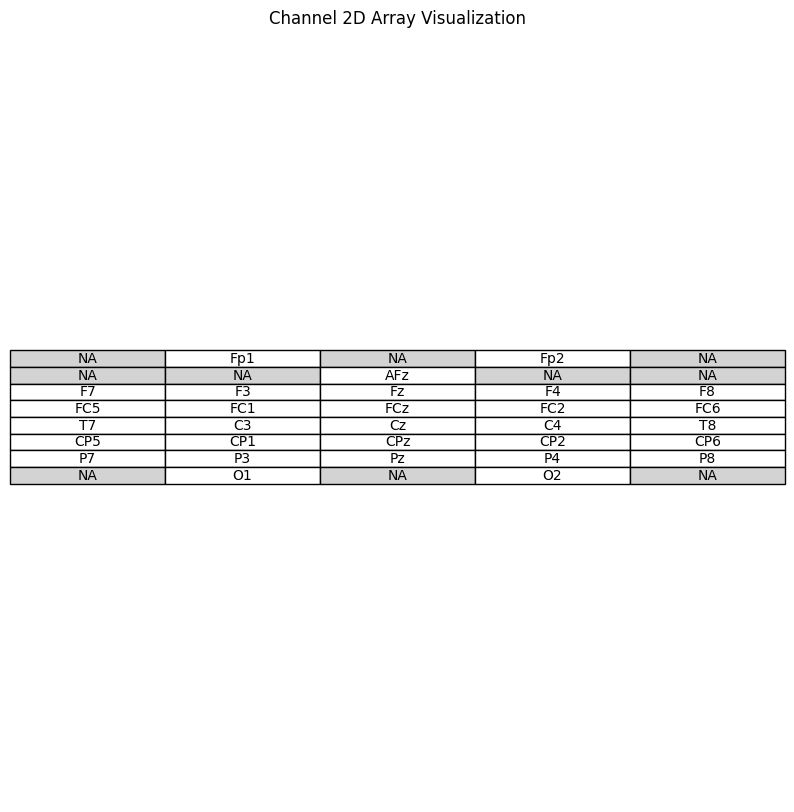

In [ ]:
from hmpai.utilities import CHANNELS_2D
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))  # Set the figure size
ax.axis("tight")
ax.axis("off")
# Create a table and populate it with the data
table_data = []
# columns = ['Col1', 'Col2', 'Col3', 'Col4', 'Col5']  # You can name columns as per your requirement
for row in CHANNELS_2D:
    table_data.append(row)

table = ax.table(cellText=table_data, cellLoc="center", loc="center")

# Optionally: Style the table with color
colors = [
    ["lightgray" if cell == "NA" else "white" for cell in row] for row in CHANNELS_2D
]
for i, row in enumerate(colors):
    for j, color in enumerate(row):
        table[(i, j)].set_facecolor(color)

plt.title("Channel 2D Array Visualization")

plt.show()

In [ ]:
import mne
from pathlib import Path

raw = mne.io.read_raw_brainvision(
    Path("/mnt/d/thesis/sat1/eeg4/MD3-0021.vhdr"), preload=False
)
raw.set_channel_types(
    {"EOGh": "eog", "EOGv": "eog", "A1": "misc", "A2": "misc"}
)  # Declare type to avoid confusion with EEG channels
raw.rename_channels({"FP1": "Fp1", "FP2": "Fp2"})  # Naming convention
raw.set_montage("standard_1020")  # Standard 10-20 electrode montage
raw.rename_channels({"Fp1": "FP1", "Fp2": "FP2"})

Extracting parameters from /mnt/d/thesis/sat1/eeg4/MD3-0021.vhdr...
Setting channel info structure...


/tmp/ipykernel_303/3749368389.py:7: RuntimeWarning: The unit for channel(s) A1, A2 has changed from V to NA.
  raw.set_channel_types(
/tmp/ipykernel_303/3749368389.py:11: RuntimeWarning: Not setting positions of 2 misc channels found in montage:
['A1', 'A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage("standard_1020")  # Standard 10-20 electrode montage


<RawBrainVision | MD3-0021.eeg, 34 x 1381968 (2763.9 s), ~45 kB, data not loaded>

In [ ]:
raw.info["sfreq"]

500.0

In [ ]:
epochs = mne.read_epochs(Path("../data/sat1/preprocessed/processed_0001_epo.fif"))

Reading /mnt/c/GIT/hmp-ai/data/sat1/preprocessed/processed_0001_epo.fif ...
    Found the data of interest:
        t =    -250.00 ...    2990.00 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
186 matching events found
No baseline correction applied
0 projection items activated


In [ ]:
epochs.info["sfreq"]

100.0

In [ ]:
%load_ext autoreload
%autoreload 2
from hmpai.generators import SAT1DataGenerator
import netCDF4
import xarray as xr
from pathlib import Path
import numpy as np
from hmpai.generators import SequentialSAT1DataGenerator
from hmpai.utilities import set_global_seed
set_global_seed(42)


2023-10-22 10:20:31.059529: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-22 10:20:31.694122: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
stage_data = xr.load_dataset(Path("../data/sat1/stage_data.nc"))
split_stage_data = xr.load_dataset(Path("../data/sat1/split_stage_data.nc"))

In [ ]:
stage_data.sel(participant="0021", epochs=46).labels

<xarray.DataArray 'labels' (samples: 199)>
array(['pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'response', 'response', 'response', 'response', 'response',
       'response', 'response', 'response', 'response', 'response',
       'response', 'response', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', ''], dtype=object)
Coordinates:
    epochs       int64 46
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.487
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'

In [ ]:
split_500 = xr.load_dataset(Path("../data/sat1/split_stage_data_unprocessed_500hz.nc"))

In [ ]:
split_500.sel(
    participant="0021", epochs=7, labels="response", channels="Fp1"
).data.isnull().argmax("samples").item()

11

In [ ]:
gen = SequentialSAT1DataGenerator(stage_data)

In [ ]:
split_gen = SAT1DataGenerator(split_stage_data)

In [ ]:
split_gen.__getitem__(0)

(<xarray.DataArray 'data' (index: 16, samples: 147, channels: 30)>
 array([[[-6.92511129e+00, -3.02646375e+00, -1.34620631e+00, ...,
           7.27705050e+00,  9.35363674e+00,  6.86937475e+00],
         [-7.83608866e+00, -5.82166195e+00, -4.60556746e-01, ...,
           7.78599501e+00,  8.95867443e+00,  5.92849112e+00],
         [-5.73718643e+00, -5.09086323e+00,  3.50992084e+00, ...,
           8.10592079e+00,  8.67707253e+00,  5.82596874e+00],
         ...,
         [ 9.99000000e+02,  9.99000000e+02,  9.99000000e+02, ...,
           9.99000000e+02,  9.99000000e+02,  9.99000000e+02],
         [ 9.99000000e+02,  9.99000000e+02,  9.99000000e+02, ...,
           9.99000000e+02,  9.99000000e+02,  9.99000000e+02],
         [ 9.99000000e+02,  9.99000000e+02,  9.99000000e+02, ...,
           9.99000000e+02,  9.99000000e+02,  9.99000000e+02]],
 
        [[-9.97322941e+00, -7.81988716e+00, -1.06438007e+01, ...,
           1.57244372e+00,  4.11288452e+00,  7.96877670e+00],
         [-4.9778175

In [ ]:
split_gen.cat_labels

['confirmation', 'decision', 'encoding', 'pre-attentive', 'response']

In [ ]:
from collections import Counter, defaultdict

counter = Counter(split_gen.full_labels.to_numpy())

total = sum(counter.values())
weights = defaultdict(lambda: 0)
for k, v in counter.items():
    idx = split_gen.cat_labels.index(k)
    weights[idx] = total / v
    # print(total / v)
print(dict(weights))

{0: 8.766069086139046, 4: 4.467023172905526, 1: 4.473003123605533, 3: 4.651508120649652, 2: 4.474001338986834}


In [ ]:
split_stage_data.labels

<xarray.DataArray 'labels' (labels: 5)>
array(['confirmation', 'decision', 'encoding', 'pre-attentive', 'response'],
      dtype=object)
Coordinates:
  * labels   (labels) object 'confirmation' 'decision' ... 'response'

In [ ]:
split_gen.__getitem__(0)

(<xarray.DataArray 'data' (index: 16, x: 8, y: 5, samples: 154)>
 array([[[[ 9.99000000e+02,  9.99000000e+02,  9.99000000e+02, ...,
            9.99000000e+02,  9.99000000e+02,  9.99000000e+02],
          [ 1.71924400e+00, -7.01414585e-01, -1.09497321e+00, ...,
            9.99000000e+02,  9.99000000e+02,  9.99000000e+02],
          [ 9.99000000e+02,  9.99000000e+02,  9.99000000e+02, ...,
            9.99000000e+02,  9.99000000e+02,  9.99000000e+02],
          [-6.68028474e-01,  1.32991850e+00,  1.37809873e+00, ...,
            9.99000000e+02,  9.99000000e+02,  9.99000000e+02],
          [ 9.99000000e+02,  9.99000000e+02,  9.99000000e+02, ...,
            9.99000000e+02,  9.99000000e+02,  9.99000000e+02]],
 
         [[ 9.99000000e+02,  9.99000000e+02,  9.99000000e+02, ...,
            9.99000000e+02,  9.99000000e+02,  9.99000000e+02],
          [ 9.99000000e+02,  9.99000000e+02,  9.99000000e+02, ...,
            9.99000000e+02,  9.99000000e+02,  9.99000000e+02],
          [-1.69680393

In [ ]:
from collections import Counter

count = Counter()
for batch in split_gen:
    for label in batch[1]:
        count[label] += 1

In [ ]:
split_stage_data.labels

<xarray.DataArray 'labels' (labels: 5)>
array(['confirmation', 'decision', 'encoding', 'pre-attentive', 'response'],
      dtype=object)
Coordinates:
  * labels   (labels) object 'confirmation' 'decision' ... 'response'

In [ ]:
count

Counter({4: 4485, 3: 4485, 2: 4484, 1: 4483, 0: 2287})

In [ ]:
gen.__getitem__(0)[1][0,]

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [ ]:
split_gen.__getitem__(0)[1].shape

(16,)

In [ ]:
# 55 samples
sample_idx = 1
data = gen.__getitem__(0)[0][sample_idx, :, 0]
labels = gen.__getitem__(0)[1][sample_idx, :]

In [ ]:
print(f"Data 999 pos: {np.where(data == 999)[0][0]}")
print(f"Labels -1 pos: {np.where(labels == -1)[0][0]}")

Data 999 pos: 55
Labels -1 pos: 55


In [ ]:
10 >= 10 - 1

True

In [ ]:
from hmpai.training import get_folds

for i in range(5):
    print(split_stage_data.participant.values)
    get_folds(split_stage_data, 5)

2023-09-26 14:13:15.151420: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 14:13:15.745206: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


['0001' '0002' '0003' '0004' '0005' '0006' '0007' '0008' '0009' '0010'
 '0011' '0012' '0013' '0014' '0015' '0016' '0017' '0018' '0019' '0020'
 '0021' '0022' '0023' '0024' '0025']
['0009' '0017' '0001' '0024' '0012' '0010' '0014' '0002' '0023' '0006'
 '0003' '0013' '0016' '0004' '0005' '0021' '0018' '0022' '0019' '0025'
 '0008' '0011' '0015' '0020' '0007']
['0001' '0002' '0003' '0004' '0005' '0006' '0007' '0008' '0009' '0010'
 '0011' '0012' '0013' '0014' '0015' '0016' '0017' '0018' '0019' '0020'
 '0021' '0022' '0023' '0024' '0025']
['0009' '0017' '0001' '0024' '0012' '0010' '0014' '0002' '0023' '0006'
 '0003' '0013' '0016' '0004' '0005' '0021' '0018' '0022' '0019' '0025'
 '0008' '0011' '0015' '0020' '0007']
['0001' '0002' '0003' '0004' '0005' '0006' '0007' '0008' '0009' '0010'
 '0011' '0012' '0013' '0014' '0015' '0016' '0017' '0018' '0019' '0020'
 '0021' '0022' '0023' '0024' '0025']
['0009' '0017' '0001' '0024' '0012' '0010' '0014' '0002' '0023' '0006'
 '0003' '0013' '0016' '0004' '0005

In [ ]:
# Create the ndarray with the channel names based on the Markdown table
channels_2d = np.array(
    [
        ["M", "Fp1", "M", "Fp2", "M"],
        ["M", "M", "AFz", "M", "M"],
        ["F7", "F3", "Fz", "F4", "F8"],
        ["FC5", "FC1", "FCz", "FC2", "FC6"],
        ["T7", "C3", "Cz", "C4", "T8"],
        ["CP5", "CP1", "CPz", "CP2", "CP6"],
        ["P7", "P3", "Pz", "P4", "P8"],
        ["M", "O1", "M", "O2", "M"],
    ],
    dtype=str,
)

print(channels_2d)

[['M' 'Fp1' 'M' 'Fp2' 'M']
 ['M' 'M' 'AFz' 'M' 'M']
 ['F7' 'F3' 'Fz' 'F4' 'F8']
 ['FC5' 'FC1' 'FCz' 'FC2' 'FC6']
 ['T7' 'C3' 'Cz' 'C4' 'T8']
 ['CP5' 'CP1' 'CPz' 'CP2' 'CP6']
 ['P7' 'P3' 'Pz' 'P4' 'P8']
 ['M' 'O1' 'M' 'O2' 'M']]


In [ ]:
dataset = split_stage_data
# Preprocess data
# Stack three dimensions into one MultiIndex dimension 'index'
dataset = dataset.stack({"index": ["participant", "epochs", "labels"]})
# Reorder so that index is at the front
dataset = dataset.transpose("index", ...)
dataset = dataset.dropna("index", how="all")

In [ ]:
len(dataset.samples)

154

In [ ]:
dataset.data.dtype

dtype('float64')

In [ ]:
# Create array full of 'empty' values (999)
reshaped_data = np.full((20234, 8, 5, 154), 999, dtype=np.float64)

# Overwrite values at each position in reshaped_data, gained from position in channels_2d
height, width = channels_2d.shape

In [ ]:
for x in range(width):
    for y in range(height):
        print(channels_2d[y, x])
        if channels_2d[y, x] == "M":
            continue
        reshaped_data[:, y, x, :] = dataset.sel(channels=channels_2d[y, x]).data

M
M
F7
FC5
T7
CP5
P7
M
Fp1
M
F3
FC1
C3
CP1
P3
O1
M
AFz
Fz
FCz
Cz
CPz
Pz
M
Fp2
M
F4
FC2
C4
CP2
P4
O2
M
M
F8
FC6
T8
CP6
P8
M


In [ ]:
# Slice of one index, all channels, one sample
reshaped_data[1, :, :, 2]

array([[ 9.99000000e+02,  7.35478306e+00,  9.99000000e+02,
         1.32752419e+01,  9.99000000e+02],
       [ 9.99000000e+02,  9.99000000e+02,  1.06792793e+01,
         9.99000000e+02,  9.99000000e+02],
       [ 2.34640813e+00, -1.90565944e+00,  8.45465565e+00,
         9.86831188e+00,  1.46217279e+01],
       [-3.91972351e+00, -3.00415444e+00,  2.70070457e+00,
         4.81988144e+00,  9.97462177e+00],
       [-5.27048492e+00, -1.66501637e+01, -5.56061649e+00,
         2.93036580e+00,  1.37563362e+01],
       [-1.89969082e+01, -1.87456570e+01, -1.06818810e+01,
        -9.08121777e+00,  6.67964745e+00],
       [-1.19519901e+01, -2.25692081e+01, -1.92385502e+01,
         7.93491006e-02,  1.12508097e+01],
       [ 9.99000000e+02, -6.07885122e+00,  9.99000000e+02,
         8.60692787e+00,  9.99000000e+02]])

In [ ]:
extra_coords = dataset.coords.to_dataset()
extra_coords = extra_coords.drop_vars("channels")
extra_coords = extra_coords.assign_coords({"x": np.arange(8), "y": np.arange(5)})

In [ ]:
extra_coords = extra_coords.assign(data=(("index", "x", "y", "samples"), reshaped_data))

In [ ]:
new_array = xr.DataArray(reshaped_data, coords=extra_coords)

In [ ]:
import netCDF4
import xarray as xr
from hmpai.training import get_folds
from pathlib import Path
import numpy as np
from copy import deepcopy

split_stage_data = xr.load_dataset(Path("../data/sat1/split_stage_data.nc"))
folds = get_folds(split_stage_data, 5)

for i in range(len(folds)):
    train_folds = deepcopy(folds)
    test_fold = train_folds.pop(i)
    train_fold = np.concatenate(train_fold, axis=0)
    print(test_fold)
    print(train_fold)

['0007' '0017' '0023' '0003' '0008']
['0025' '0001' '0014' '0020' '0021' '0015' '0010' '0016' '0024' '0018'
 '0019' '0005' '0011' '0022' '0002' '0013' '0009' '0012' '0006' '0004']
['0025' '0001' '0014' '0020' '0021']
['0007' '0017' '0023' '0003' '0008' '0015' '0010' '0016' '0024' '0018'
 '0019' '0005' '0011' '0022' '0002' '0013' '0009' '0012' '0006' '0004']
['0015' '0010' '0016' '0024' '0018']
['0007' '0017' '0023' '0003' '0008' '0025' '0001' '0014' '0020' '0021'
 '0019' '0005' '0011' '0022' '0002' '0013' '0009' '0012' '0006' '0004']
['0019' '0005' '0011' '0022' '0002']
['0007' '0017' '0023' '0003' '0008' '0025' '0001' '0014' '0020' '0021'
 '0015' '0010' '0016' '0024' '0018' '0013' '0009' '0012' '0006' '0004']
['0013' '0009' '0012' '0006' '0004']
['0007' '0017' '0023' '0003' '0008' '0025' '0001' '0014' '0020' '0021'
 '0015' '0010' '0016' '0024' '0018' '0019' '0005' '0011' '0022' '0002']


In [ ]:
split_stage_data.channels

<xarray.DataArray 'channels' (channels: 30)>
array(['Fp1', 'Fp2', 'AFz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz',
       'C4', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2', 'FC1', 'FCz',
       'FC2', 'FC5', 'FC6', 'CP5', 'CP1', 'CPz', 'CP2', 'CP6'], dtype=object)
Coordinates:
  * channels  (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'

In [ ]:
import numpy as np

test_split = split_stage_data.sel(
    participant="0021", labels="confirmation", channels="Fp1"
).data

nan_ct = 0
for i in test_split:
    if np.all(np.isnan(i)):
        nan_ct += 1

print(nan_ct)

121


In [ ]:
test_split.sel(epochs=11)

<xarray.DataArray 'data' (samples: 157)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan])
Coordinates:
    channels     <U3 'Fp1'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 150 151 152 153 154 155 156
    epochs       int64 11
    participant  <U4 '0021'
    labels       <U12 'confirmation'
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.5
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'

In [ ]:
stage_data.sel(participant="0021", epochs=11).labels

<xarray.DataArray 'labels' (samples: 199)>
array(['', '', '', '', '', '', '', '', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'response', 'response',
       'response', 'response', 'response', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', ''], dtype=object)
Coordinates:
    epochs       int64 11
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.5
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'

In [ ]:
stage_data.sel(participant="0021", epochs=0, channels="Fp1").data

<xarray.DataArray 'data' (samples: 199)>
array([ -1.4485786 ,  -3.42640352,  -2.4117887 ,  -0.18200085,
        -0.80526227,   1.35877502,   3.02365875,  -0.02237152,
        -2.25271702,  -2.42085075,   0.2947644 ,  -0.91509807,
        -5.1842823 ,  -1.44319379,  -0.2521725 ,  -2.26326203,
         0.07126679,  -3.59668231,  -6.76995134,  -5.46194267,
        -7.99716139,  -8.59681225,  -9.54486752, -11.66129684,
        -9.17194557, -10.2177906 , -11.75735283,  -8.43788433,
        -7.39112139,  -6.80812454,  -5.31452036,  -6.099473  ,
        -8.99092007, -10.56101894, -10.28787231, -12.66547203,
       -11.95652103, -11.66712856, -16.60264206, -12.8394289 ,
        -6.12484169,  -5.29754734,  -4.22220325,  -5.32257748,
        -6.30005026,  -5.65012074,  -5.61978436,  -4.06413412,
        -6.74995422, -13.03981876, -13.00213528,  -9.78717136,
        -7.76501513,  -4.36741066,  -3.86855841,  -3.96473646,
         0.38768536,  -0.46019372,  -5.48295164,  -7.29868031,
        -8.10804272,  -5.44400549,  -2.07789779,  -2.69890881,
        -3.05435443,  -1.92624545,  -0.14473617,   0.37756139,
        -2.76270151,  -7.17918777,  -5.1225543 ,   3.04851437,
         3.38843966,  -2.50560665,  -3.44783115,  -1.60542727,
         2.50471473,   4.25936651,  -1.33009636,  -4.54194355,
...
        -3.21348286,   1.01611722,  -0.4804104 ,  -4.67927265,
        -4.66788387,  -0.91285044,   1.35201216,  -1.5154686 ,
        -4.36229181,  -4.3813324 ,  -7.11054659,  -5.92612839,
        -1.77631462,  -7.35063696, -10.16974068,  -4.92261553,
        -4.57410526,  -5.88248634,  -7.53590775,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan])
Coordinates:
    epochs       int64 0
    channels     <U3 'Fp1'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.388
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'

In [ ]:
#### LOOCV
estimates = model_all.fit(step=1)

max_fit = model_all.fit_single(n_events=8)
hmp.visu.plot_topo_timecourse(eeg_data, max_fit, positions, model_all)

bests = model_all.backward_estimation()

hmp.visu.plot_topo_timecourse(
    eeg_data, bests, positions, model_accuracy, ydim="n_events"
)
plt.plot(bests.n_events, bests.likelihoods, "o-")

plt.ylabel("Log-likelihood")
plt.xlabel("N-event model")
plt.show()
loocv = hmp.utils.loocv_mp(model_all, hmp_data, bests, cpus=4)

In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


2023-07-11 12:59:50.433177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-11 12:59:50.533576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-11 12:59:50.533645: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.


In [ ]:
# Old code from process_model:
# Takes a model and the probabilities of events occuring within the dataset the model was initiated on
# and returns an ndarray of shape samples x time x #electrodes
# length of labels must be equal to amount of events
def process_model(model, eeg_data, labels):
    n_events = len(model.event)
    if len(labels) != n_events:
        raise ValueError(
            "Amount of labels is not equal to amount of events, adjust labels parameter"
        )

    # Set up output datatypes
    event_locations = model.eventprobs.idxmax(dim="samples").astype(int)
    labels_array = np.full(eeg_data.data.shape, fill_value=np.nan)
    participants = list(eeg_data.participant.values)
    # output_data = []
    # stage_data = []
    # stage_labels = []
    # participant_labels = []
    # epochs = []

    # For every known set of event locations, find the EEG data belonging to that trial (epoch) and participant
    for locations, data in zip(event_locations, model.trial_x_participant):
        data = data.item()
        locations = locations.values
        print(f"Processing participant {data[0]} and epoch {data[1]}")
        # t_x_p_data = int(eeg_data.sel(participant=data[0], epochs=data[1]).isnull().argmax('samples').data[0])
        # TODO Maybe not reliable enough, what if electrode 0 (Fp1) is working but others are not
        # Find sample for combination of participant + epoch where the value is null, this is the reaction time sample
        # where the participant pressed the button and the last stage ends
        RT_sample = int(
            eeg_data.sel(participant=data[0], epochs=data[1])
            .isnull()
            .argmax("samples")
            .data[0]
        )
        participant = participants.index(data[0])
        epoch = data[1]

        # Instead of all this, add dimension to dataarray with labels
        for j, location in enumerate(locations):
            # Slice from known event location n to known event location n + 1
            # unless it is the last event, then slice from known event location n to reaction time
            samples_slice = (
                slice(location, locations[j + 1])
                if j != n_events - 1
                else slice(location, RT_sample - 1)
            )
            # print(samples_slice, j)
            # TODO: Works right after, reset back to zero after this for loop
            labels_array[participant, epoch, :, samples_slice] = j
        # print(np.where(labels_array[participant, epoch, :, :]!= 0))

        # Do not record final stage if the last event bump is after the recorded reaction time
        # In this case, previous slices will have contained NaN values and have been skipped
        # if j == n_events - 1 and location > RT_sample:
        #     continue

        # eeg_slice = t_x_p_data.sel(samples=samples_slice)['data']

        # Disregard slices with NaN/None values
        # if eeg_slice.isnull().any():
        #     continue

        # Pad data to 'max' sample length
        # TODO: Look into max sample length
        # eeg_slice = eeg_slice.pad(pad_width={'samples': (0, 199 - len(eeg_slice['samples']))}, mode='constant', constant_values=0)
        # output_data.append((
        #     data[0], # participant
        #     data[1], # epoch
        #     eeg_slice
        # ))
        # stage_data.append(eeg_slice.pad(pad_width={'samples': (0, 199 - len(eeg_slice['samples']))}, mode='constant', constant_values=0))
        # stage_labels.append(labels[j])
        # participant_labels.append(data[0])
        # epochs.append(data[1])

    # stage_data = np.array(stage_data, dtype=np.float64)
    # participant, epochs, channels, samples
    # acc_xds = xr.Dataset(
    #     data_vars=dict(
    #         labels=(['participant', 'epochs', 'channels', 'samples'], acc_data),
    #         data=eeg_data.data
    #     )
    # )
    return labels_array